IMPORT ALL REQUIRED LIBRARIES

In [5]:
#Any library that has to be used will be imported here:

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import tensorflow as tf
import keras
from glob import glob
from tensorflow import keras

from keras.preprocessing.image import load_img
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Conv2D , MaxPool2D , Dropout , BatchNormalization, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from keras.preprocessing import image 
from keras.models import load_model 
from keras.applications.vgg16 import preprocess_input 




SET DIRECTORIES

In [8]:

training_directory = 'D:/LABS/AI/data/train'               #path for training data
testing_directory = 'D:/LABS/AI/data/test'                 #path for testing data
validation_directory='D:\/LABS/AI/data/val'                #path for validation data
train_normal_directory = 'D:/LABS/AI/data/train/NORMAL/'         ##path for normal training data
train_pneumonia_directory = 'D:/LABS/AI/data/train/PNEUMONIA/'   #path for pneumonia training data
test_normal_directory = 'D:/LABS/AI/data/test/NORMAL/'           #path for normal testing data
test_pneumonia_directory = 'D:/LABS/AI/data/test/PNEUMONIA/'     #path for pneumonia testing data
val_normal_directory = 'D:/LABS/AI/data/val/NORMAL/'             #path for normal validation data
val_pneumonia_directory = 'D:/LABS/AI/data/val/PNEUMONIA/'       #path for pneumonia validation data

GET DATA

In [9]:
#We do this by using ImageDataGenerator

training_generator=ImageDataGenerator(rescale=1/255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
training_data=training_generator.flow_from_directory(
    training_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

#For the testing data
testing_generator=ImageDataGenerator(rescale=1/255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
testing_data=testing_generator.flow_from_directory(
    testing_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

#For the validation data
validation_generator=ImageDataGenerator(rescale=1/255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
validation_data=validation_generator.flow_from_directory(
    validation_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


DISPLAY PNEUMONIA IMAGES

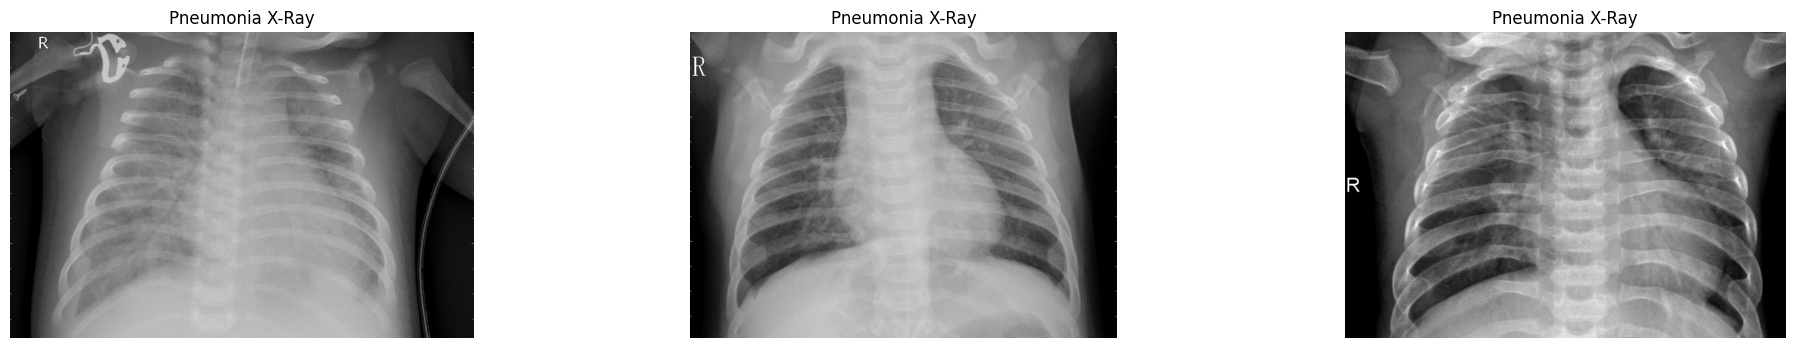

In [42]:
pneumonia = os.listdir(train_pneumonia_directory)
pneumonia_dir = train_pneumonia_directory

plt.figure(figsize=(20, 10))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray") 
plt.tight_layout()

DISPLAY NORMAL IMAGES

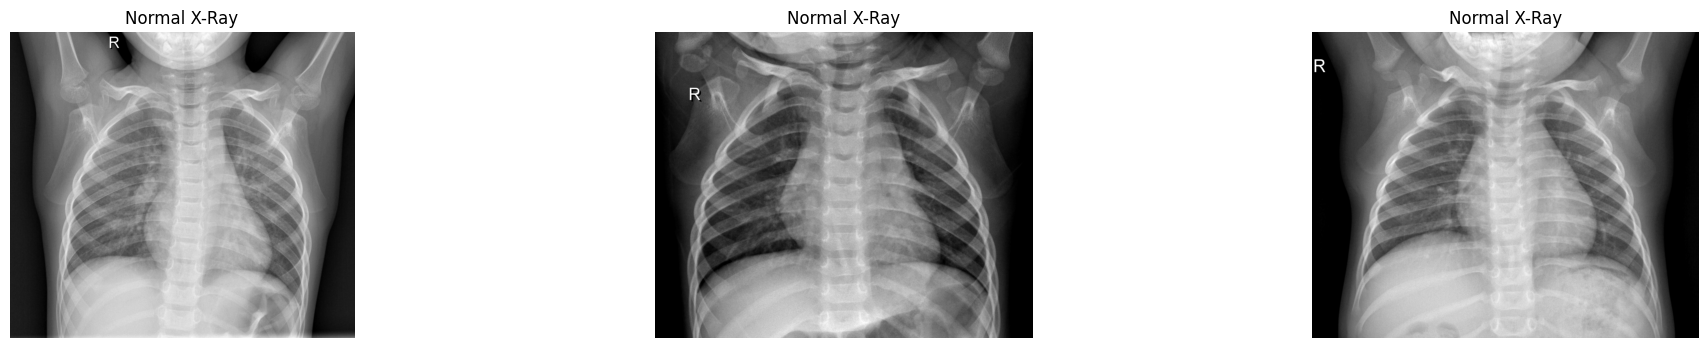

In [89]:
normal = os.listdir(train_normal_directory)
normal_dir = train_normal_directory

plt.figure(figsize=(20, 10))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray") 
plt.tight_layout()

CREATE LISTS OF IMAGES

In [44]:
# find all files, our files has extension jpeg

train_normal_cases = glob(train_normal_directory + '*jpeg')
train_pneumonia_cases = glob(train_pneumonia_directory + '*jpeg')

test_normal_cases = glob(test_normal_directory + '*jpeg')
test_pneumonia_cases = glob(test_pneumonia_directory + '*jpeg')

val_normal_cases = glob(val_normal_directory + '*jpeg')
val_pneumonia_cases = glob(val_pneumonia_directory + '*jpeg')

# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneumonia_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneumonia_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneumonia_cases:
    val_list.append([x, 1])

MAKE DATAGRAMS

In [27]:
# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])


,image,label
0,D:/LABS/AI/data/train/NORMAL\IM-0115-0001.jpeg,0
1,D:/LABS/AI/data/train/NORMAL\IM-0117-0001.jpeg,0
2,D:/LABS/AI/data/train/NORMAL\IM-0119-0001.jpeg,0
3,D:/LABS/AI/data/train/NORMAL\IM-0122-0001.jpeg,0
4,D:/LABS/AI/data/train/NORMAL\IM-0125-0001.jpeg,0
...,...,...
5211,D:/LABS/AI/data/train/PNEUMONIA\person99_virus...,1
5212,D:/LABS/AI/data/train/PNEUMONIA\person9_bacter...,1
5213,D:/LABS/AI/data/train/PNEUMONIA\person9_bacter...,1
5214,D:/LABS/AI/data/train/PNEUMONIA\person9_bacter...,1


PLOT GRAPHS

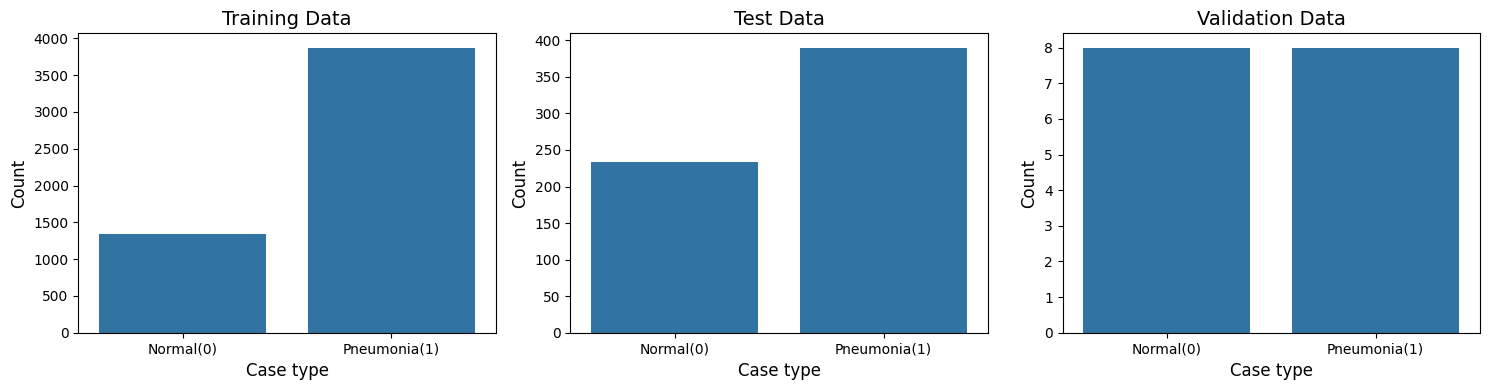

In [14]:
def plot_cases_count(df, title, ax):
    cases_count = df['label'].value_counts()
    
    sns.barplot(x=cases_count.index, y= cases_count.values, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Case type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks(range(len(cases_count.index)))
    ax.set_xticklabels(['Normal(0)', 'Pneumonia(1)'])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for Training Data
plot_cases_count(train_df, 'Training Data', axes[0])

# Plot for Test Data
plot_cases_count(test_df, 'Test Data', axes[1])

# Plot for Validation Data
plot_cases_count(val_df, 'Validation Data', axes[2])

plt.tight_layout()
plt.show()

DISPLAY BOTH TYPES OF IMAGES

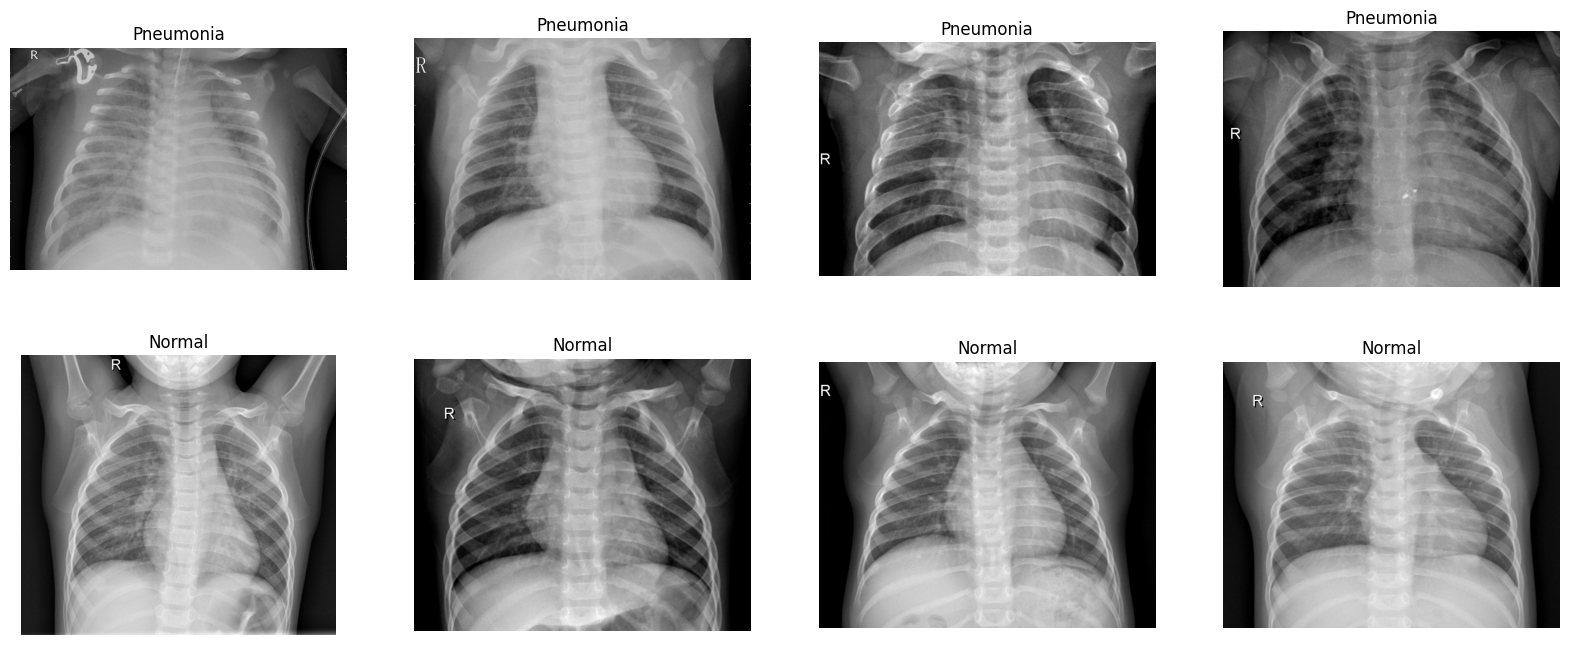

In [12]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

PROCESS DATA

In [18]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (224,224,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

PREPARE AND AUGMENT DATA BEFORE TRAINING

In [14]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))



Train data shape: (5216, 224, 224, 1), Labels shape: (5216,)
Test data shape: (624, 224, 224, 1), Labels shape: (624,)
Validation data shape: (16, 224, 224, 1), Labels shape: (16,)


In [15]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

MODEL CREATION

In [ ]:
# Create a Sequential model
model = Sequential()

# First Convolutional layer with 16 filters, kernel size of (7,7), ReLU activation function, and input shape of (224, 224, 1)
model.add(Conv2D(filters=16, kernel_size=(7,7), padding='valid', activation='relu', input_shape=(224, 224, 1)))

# Second Convolutional layer with 16 filters, kernel size of (7,7), and ReLU activation function
model.add(Conv2D(filters=16, kernel_size=(7,7), padding='valid', activation='relu'))


# MaxPooling layer with pool size of (3,3)
model.add(MaxPooling2D(pool_size=(3,3)))

# Third Convolutional layer with 32 filters, kernel size of (5,5), and ReLU activation function
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))

# Fourth Convolutional layer with 32 filters, kernel size of (5,5), and ReLU activation function
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu'))

# MaxPooling layer with pool size of (3,3)
model.add(MaxPooling2D(pool_size=(3,3)))

# Fifth Convolutional layer with 64 filters, kernel size of (3,3), and ReLU activation function
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))

# Sixth Convolutional layer with 64 filters, kernel size of (3,3), and ReLU activation function
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))

# Seventh Convolutional layer with 128 filters, kernel size of (3,3), and ReLU activation function
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))

# MaxPooling layer with pool size of (2,2)
model.add(MaxPooling2D(pool_size=(2,2)))

# Seventh Convolutional layer with 128 filters, kernel size of (3,3), and ReLU activation function
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))

# Eighth Convolutional layer with 128 filters, kernel size of (3,3), and ReLU activation function
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))

# MaxPooling layer with pool size of (2,2)
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer to convert 2D features to 1D
model.add(Flatten())

# First Dense (fully connected) layer with 128 neurons and ReLU activation function
model.add(Dense(128, activation='relu'))

# Dropout layer with dropout rate of 0.2 to prevent overfitting
model.add(Dropout(0.2))

# Output Dense layer with 2 neurons (since it's a binary classification task) and softmax activation function
model.add(Dense(2, activation='softmax'))


# Compile the model with Adam optimizer, categorical crossentropy loss function, and accuracy metric
optimizer = Adam(learning_rate=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early stopping callback to stop training if loss stops decreasing
callback = EarlyStopping(monitor='loss', patience=6)

# Train the model with training data generated by data generator, and validate on testing data
history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 100, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})


In [18]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9388 - loss: 0.1775
Loss of the model is -  0.16311097145080566
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9388 - loss: 0.1775
Accuracy of the model is -  94.2307710647583 %


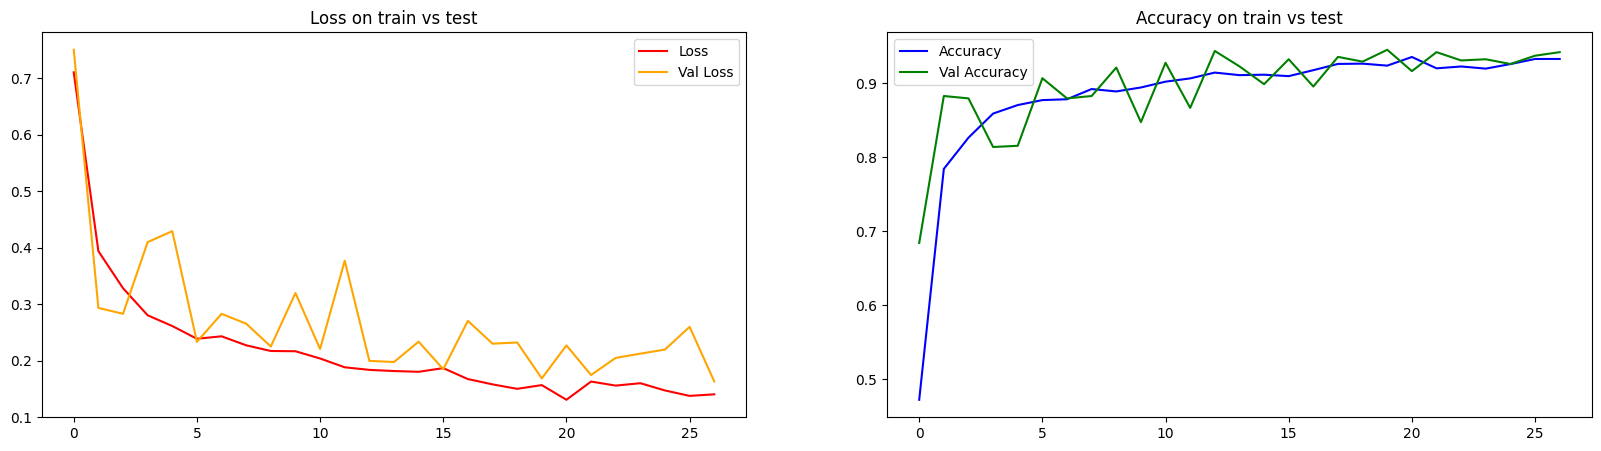

In [19]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()

In [20]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


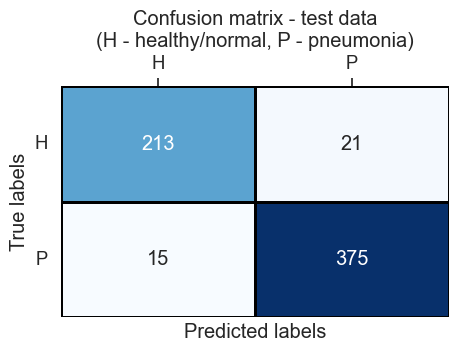

Classification report on test data
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       234
           1       0.95      0.96      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624



In [21]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'P'], yticklabels=['H', 'P'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top') 
plt.title('Confusion matrix - test data\n(H - healthy/normal, P - pneumonia)')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)

In [22]:
model.save("CNN1.h5")

In [33]:
model_path = 'D:/LABS/AI/AI Project/CNN1.h5'
loaded_model = load_model(model_path)
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    img = np.reshape(img, (1, 224, 224, 1))  # Add batch dimension
    return img

image_path = 'C:/Users/itiss/Desktop/img.jpeg'
image = preprocess_image(image_path)


predictions = loaded_model.predict(image)
# Interpret predictions as probabilities for each class
probability_normal = predictions[0][0]  # Probability for Normal/Healthy class
probability_pneumonia = predictions[0][1]  # Probability for Pneumonia class

# Print the probabilities for each class
print("Probability for Normal/Healthy class:", probability_normal)
print("Probability for Pneumonia class:", probability_pneumonia)

# Predict the class with highest probability
predicted_class = np.argmax(predictions)

# Print the predicted class
if predicted_class == 0:
    print("The image is predicted as Healthy/Normal")
else:
    print("The image is predicted as Pneumonia")





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Probability for Normal/Healthy class: 0.009475597
Probability for Pneumonia class: 0.9905245
The image is predicted as Pneumonia


MODEL2 - VGG16


In [12]:
data_classes=glob('D:/LABS/AI/data/train/*')
#So that we can train the data properly and categorically
print(data_classes)

['D:/LABS/AI/data/train\\NORMAL', 'D:/LABS/AI/data/train\\PNEUMONIA']


In [57]:
#Now we work on our VGG16 model
#Since Ma'am allowed us to use pre-built models
#The first that we will utilize is VGG-16
vgg_model= VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3), pooling = "max", classes = 2)
#We allow for maximum pooling
#We want 224x224 height width and 3 means RGB image

flatten_layer=Flatten()(vgg_model.output)
#The flatten command will help to convert output into 1D array
potential_predictions=Dense(len(data_classes),activation='softmax')(flatten_layer)
#This will add a dense layer with softmax activation function 

#Since we are using a pre-built VGG16 model we would want to freeze all
#of its already existing layers so that we dont touch its weights
for layer in vgg_model.layers:
    layer.trainable=False

#We want to optimize VGG-16 a little bit so lets add it to our optimized model
optimized_model=Model(inputs=vgg_model.input,outputs=potential_predictions)
#In this optimized model of VGG16 we have just added the flatten and dense layers
optimized_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#This was shown to be a preferred practice when dealing with images

#Now we want to fit our optimized model and evaluate it on the training data
#For this we decided to choose 10 epochs
testing=optimized_model.fit(training_data,validation_data=testing_data,epochs=10)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 630s 4s/step - accuracy: 0.7614 - loss: 0.5025 - val_accuracy: 0.7644 - val_loss: 0.4477
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 626s 4s/step - accuracy: 0.8999 - loss: 0.2506 - val_accuracy: 0.8285 - val_loss: 0.3767
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 629s 4s/step - accuracy: 0.9265 - loss: 0.2070 - val_accuracy: 0.8269 - val_loss: 0.3786
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 630s 4s/step - accuracy: 0.9283 - loss: 0.1918 - val_accuracy: 0.8397 - val_loss: 0.3616
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 631s 4s/step - accuracy: 0.9272 - loss: 0.1835 - val_accuracy: 0.8333 - val_loss: 0.3851
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 637s 4s/step - accuracy: 0.9411 - loss: 0.1636 - val_accuracy: 0.7965 - val_loss: 0.4669
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 636s 4s/step - accuracy: 0.9398 - loss: 0.1602 - val_accuracy: 0.8542 - val_loss: 0.3784
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 627s 4s/step - accuracy: 0.9422 - loss: 0.1470 - val_accu

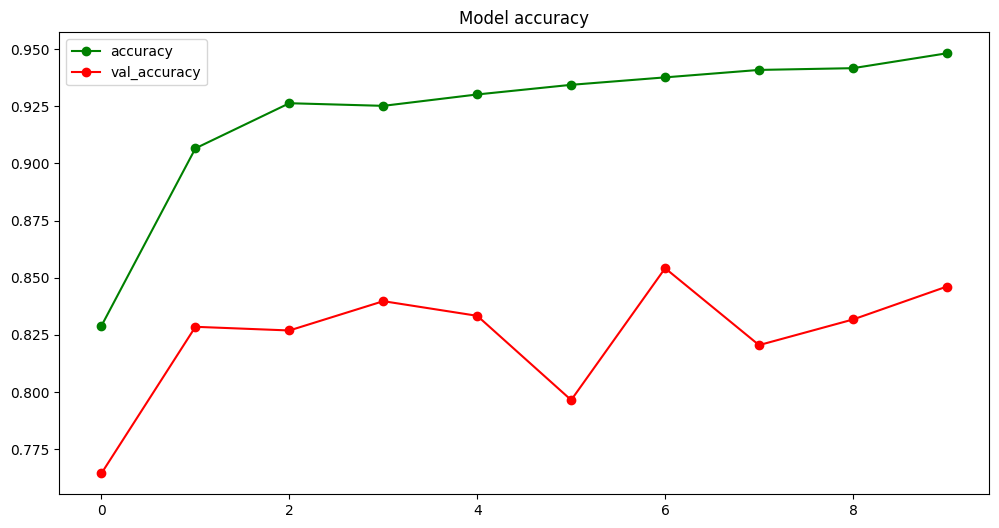

In [58]:
#Now we want to visualize a graph to get an idea of our
#Normal Accuracy and Valid Accuracy
plt.figure(figsize = (12, 6))
##################################################
plt.title("Model accuracy")
#g for green color, o for circles and '-' for solid line
plt.plot(testing.history["accuracy"], "go-")
#r for red color, o for circles and '-' for solid line
plt.plot(testing.history["val_accuracy"], "ro-")
#This legend command is simply used to proivde info about the different
#plotted lines
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [59]:
#Now that we have trained our VGG16 optimized model lets evaluate its performance
#On both the training and testing datasets of ours
train_accuracy=optimized_model.evaluate(training_data)[1]
test_accuracy=optimized_model.evaluate(testing_data)[1]
print('Accuracy of VGG16')
print('Training Accuracy: ',train_accuracy,'\nTesting Accuracy: ',test_accuracy)

163/163 ━━━━━━━━━━━━━━━━━━━━ 605s 4s/step - accuracy: 0.9428 - loss: 0.1553
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.8647 - loss: 0.3386
Accuracy of VGG16
Training Accuracy:  0.9445935487747192 
Testing Accuracy:  0.8637820482254028


In [60]:
optimized_model.save("VGG16.h5")

In [6]:
# Load the trained VGG16 model
model_path = 'D:/LABS/AI/AI Project/VGG16.h5'
loadedModel = load_model(model_path)

20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step


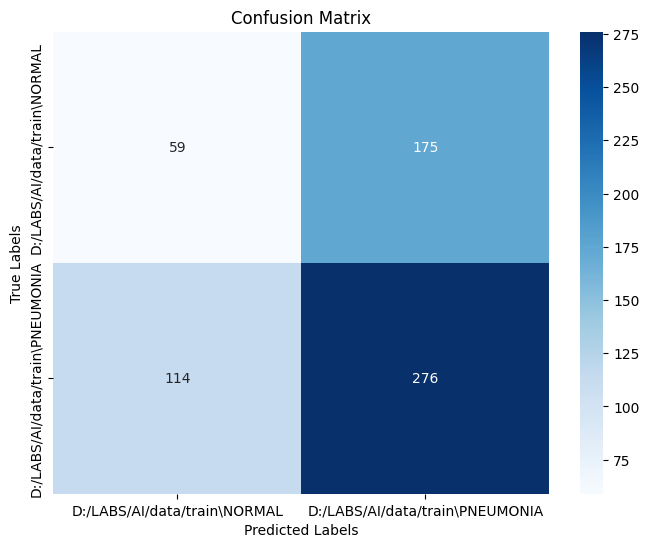

In [13]:
# Perform inference on the testing data using the optimized model
predictions = loadedModel.predict(testing_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)  

# Get the true labels of the testing data
true_labels = testing_data.classes

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=data_classes, yticklabels=data_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [98]:
# Load the pre-trained VGG16 model from the file 'VGG16.h5'
model = load_model('VGG16.h5')

# Load the image from the specified path and resize it to the target size of (224, 224)
img = image.load_img('C:/Users/itiss/Desktop/img.jpeg', target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add a batch dimension to the image array
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the input image data according to the requirements of the VGG16 model
img_data = preprocess_input(img_array)

# Make predictions using the VGG16 model on the preprocessed image data
prediction = model.predict(img_data)

# Interpret predictions and print the predicted class and prediction probabilities
if prediction[0][0] > prediction[0][1]:
    print('The image is predicted as Healthy/Normal.')
else:
    print('The image is predicted as Pneumonia.')

# Print the prediction probabilities
print(f'Predictions: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Person is affected with Pneumonia.
Predictions: [[0.18743636 0.81256366]]


MODEL 3 - RESTNET

In [68]:
trainingData = tf.keras.preprocessing.image_dataset_from_directory(training_directory, seed=100)
testingData = tf.keras.preprocessing.image_dataset_from_directory(testing_directory, seed=100)
validationData = tf.keras.preprocessing.image_dataset_from_directory(validation_directory,seed=100)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [ ]:
Model = tf.keras.applications.ResNet50V2(weights = "imagenet",input_shape = (256, 256, 3),pooling = "max", include_top = False,classes = 2)

for layer in Model.layers:
    layer.trainable = False

ResNet_Model = Sequential()
ResNet_Model.add(Model)
ResNet_Model.add(Flatten())

ResNet_Model.add(Dense(128, activation = "relu"))
ResNet_Model.add(Dense(64, activation = "relu"))
ResNet_Model.add(Dense(32, activation = "relu"))
ResNet_Model.add(Dense(1, activation = "sigmoid"))

for layer in Model.layers:
    layer.trainable = False

ResNet_Model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

training_data = training_data.repeat()
testing = ResNet_Model.fit(training_data, epochs = 10, validation_data = validation_data, steps_per_epoch = 163,)



In [ ]:
plt.figure(figsize = (12, 6))
plt.title("Model accuracy")
plt.plot(testing.history["accuracy"], "go-")
plt.plot(testing.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [ ]:
train_accuracy = ResNet_Model.evaluate(training_data)[1]
test_accuracy = ResNet_Model.evaluate(testing_data)[1]
print('Accuracy of ResNet50')
print('Training Accuracy: ',train_accuracy,'\nTesting Accuracy: ',test_accuracy)